In [1]:
import renderapi
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import time

from matplotlib.patches import FancyArrowPatch, Circle, ConnectionStyle

%matplotlib notebook

In [2]:
host = 'ibs-forrestc-ux1.corp.alleninstitute.org'
port = 8080
owner = 'Sharmishtaas'
project = 'M270907_Scnn1aTg2Tdt_13'
stack = 'ALIGNEDSTACK_JAN3_DAPI_1_NORM'
matchcollection = 'large_rigid_run'
render = renderapi.Render(host,port,owner,project)

In [3]:
render.get_matchcollection_owners()

[u'Forrest', u'Sharmishtaas']

In [4]:
render.get_matchcollections()

[{u'collectionId': {u'name': u'rigid_sift_half_scale_fullrun',
   u'owner': u'Sharmishtaas'},
  u'pairCount': 349937},
 {u'collectionId': {u'name': u'rigid_sift_run2', u'owner': u'Sharmishtaas'},
  u'pairCount': 3817},
 {u'collectionId': {u'name': u'rigid_sift_half_scale_run2',
   u'owner': u'Sharmishtaas'},
  u'pairCount': 193240},
 {u'collectionId': {u'name': u'norm_sift_run1', u'owner': u'Sharmishtaas'},
  u'pairCount': 384058},
 {u'collectionId': {u'name': u'rigid_sift_run1', u'owner': u'Sharmishtaas'},
  u'pairCount': 16679},
 {u'collectionId': {u'name': u'tilepairtest', u'owner': u'Sharmishtaas'},
  u'pairCount': 2},
 {u'collectionId': {u'name': u'large_rigid_run', u'owner': u'Sharmishtaas'},
  u'pairCount': 3508512},
 {u'collectionId': {u'name': u'rigid_sift_half_scale_run1',
   u'owner': u'Sharmishtaas'},
  u'pairCount': 15845},
 {u'collectionId': {u'name': u'rigid_sift_run3', u'owner': u'Sharmishtaas'},
  u'pairCount': 19313}]

In [5]:
allmatches=render.get_matches_from_group_to_group(matchcollection,'0','1')

<IPython.core.display.Javascript object>


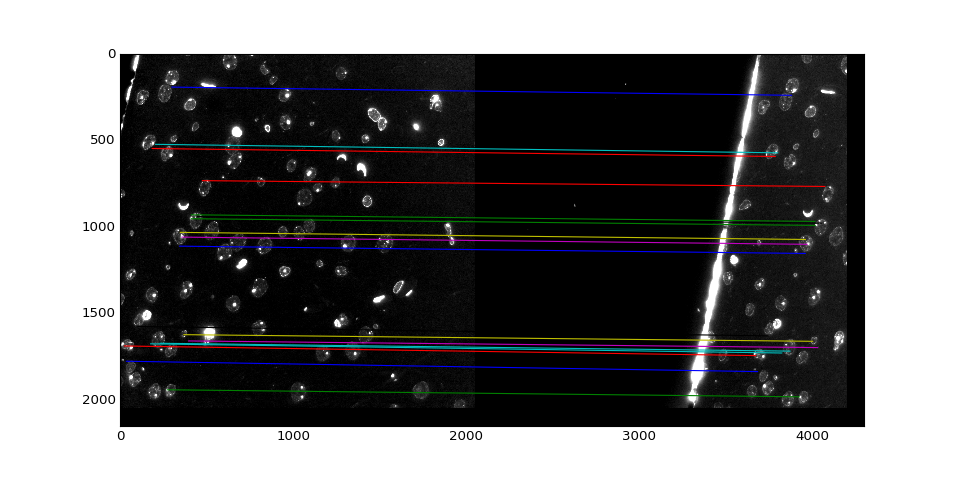

In [6]:
def draw_matches(matches,render):
    ptile = render.get_tile_image_data(stack,matches['pId'])[:,:,0]
    qtile = render.get_tile_image_data(stack,matches['qId'])[:,:,0]

    imgjoin = np.concatenate([ptile,qtile],axis=1)
    f,ax = plt.subplots(1,1,figsize=(12,6))
    ax.imshow(imgjoin,cmap=plt.cm.gray)
    pwidth = ptile.shape[1]
    ppoints = np.array(matches['matches']['p'])
    qpoints = np.array(matches['matches']['q'])
    qpoints[0,:]+=pwidth
    totpoints = np.concatenate([ppoints,qpoints],axis=0)
    ax.plot(totpoints[0:5:2,:],totpoints[1:5:2,:])
    ax.autoscale(tight=True)

draw_matches(allmatches[10],render)

In [7]:
groups=render.get_match_groupIds(matchcollection)
groups=np.array(map(int,groups))
groups.sort()

In [8]:
np.where(groups==1000)[0][0]

27

In [9]:
import pathos.multiprocessing as mp
pool = mp.ProcessingPool(40)
def process_group(group):
    matches = render.get_matches_outside_group(matchcollection,group)
    N=len(groups)
    matchcounts = {}
    for match in matches:
        qid = match['qGroupId']
        pid = match['pGroupId']
        if int(qid)==group:
            otherid= int(pid)
        else:
            otherid = int(qid)
        #j=np.where(groups==otherid)[0][0]
        if otherid in matchcounts.keys():
            matchcounts[otherid]+=1
        else:
            matchcounts[otherid]=1
    return matchcounts
now =time.time()
answers=pool.map(process_group,groups)
print time.time()-now

61.0746269226


In [32]:

zvalues = {}
for group in groups:
    z = render.get_z_value_for_section(stack,group)
    zvalues[group]=int(z)
maxz=np.max(zvalues.values())
maxdz = 12
match_matrix = np.zeros((maxz+1,2*maxdz + 1))

for answer,group in zip(answers,groups):
    #print group,zvalues[group]
    z1 = zvalues[group]
    if z1==1248:
        print group
    for group2 in answer.keys():
        z2 = zvalues[group2]
        val = answer[group2]
        if np.abs(z2-z1)<=maxdz:
            match_matrix[z1,z2-z1+maxdz]+=val
            match_matrix[z2,z1-z2+maxdz]+=val
            
        
        

46004


In [41]:
len(answers),maxz,len(groups)
print render.get_z_value_for_section(stack,'46004')
print np.where(np.array(zvalues.values())==1248)
print zvalues[46004]
print zvalues.keys()[2019]

1248.0
(array([2019]),)
1248
46004


<IPython.core.display.Javascript object>


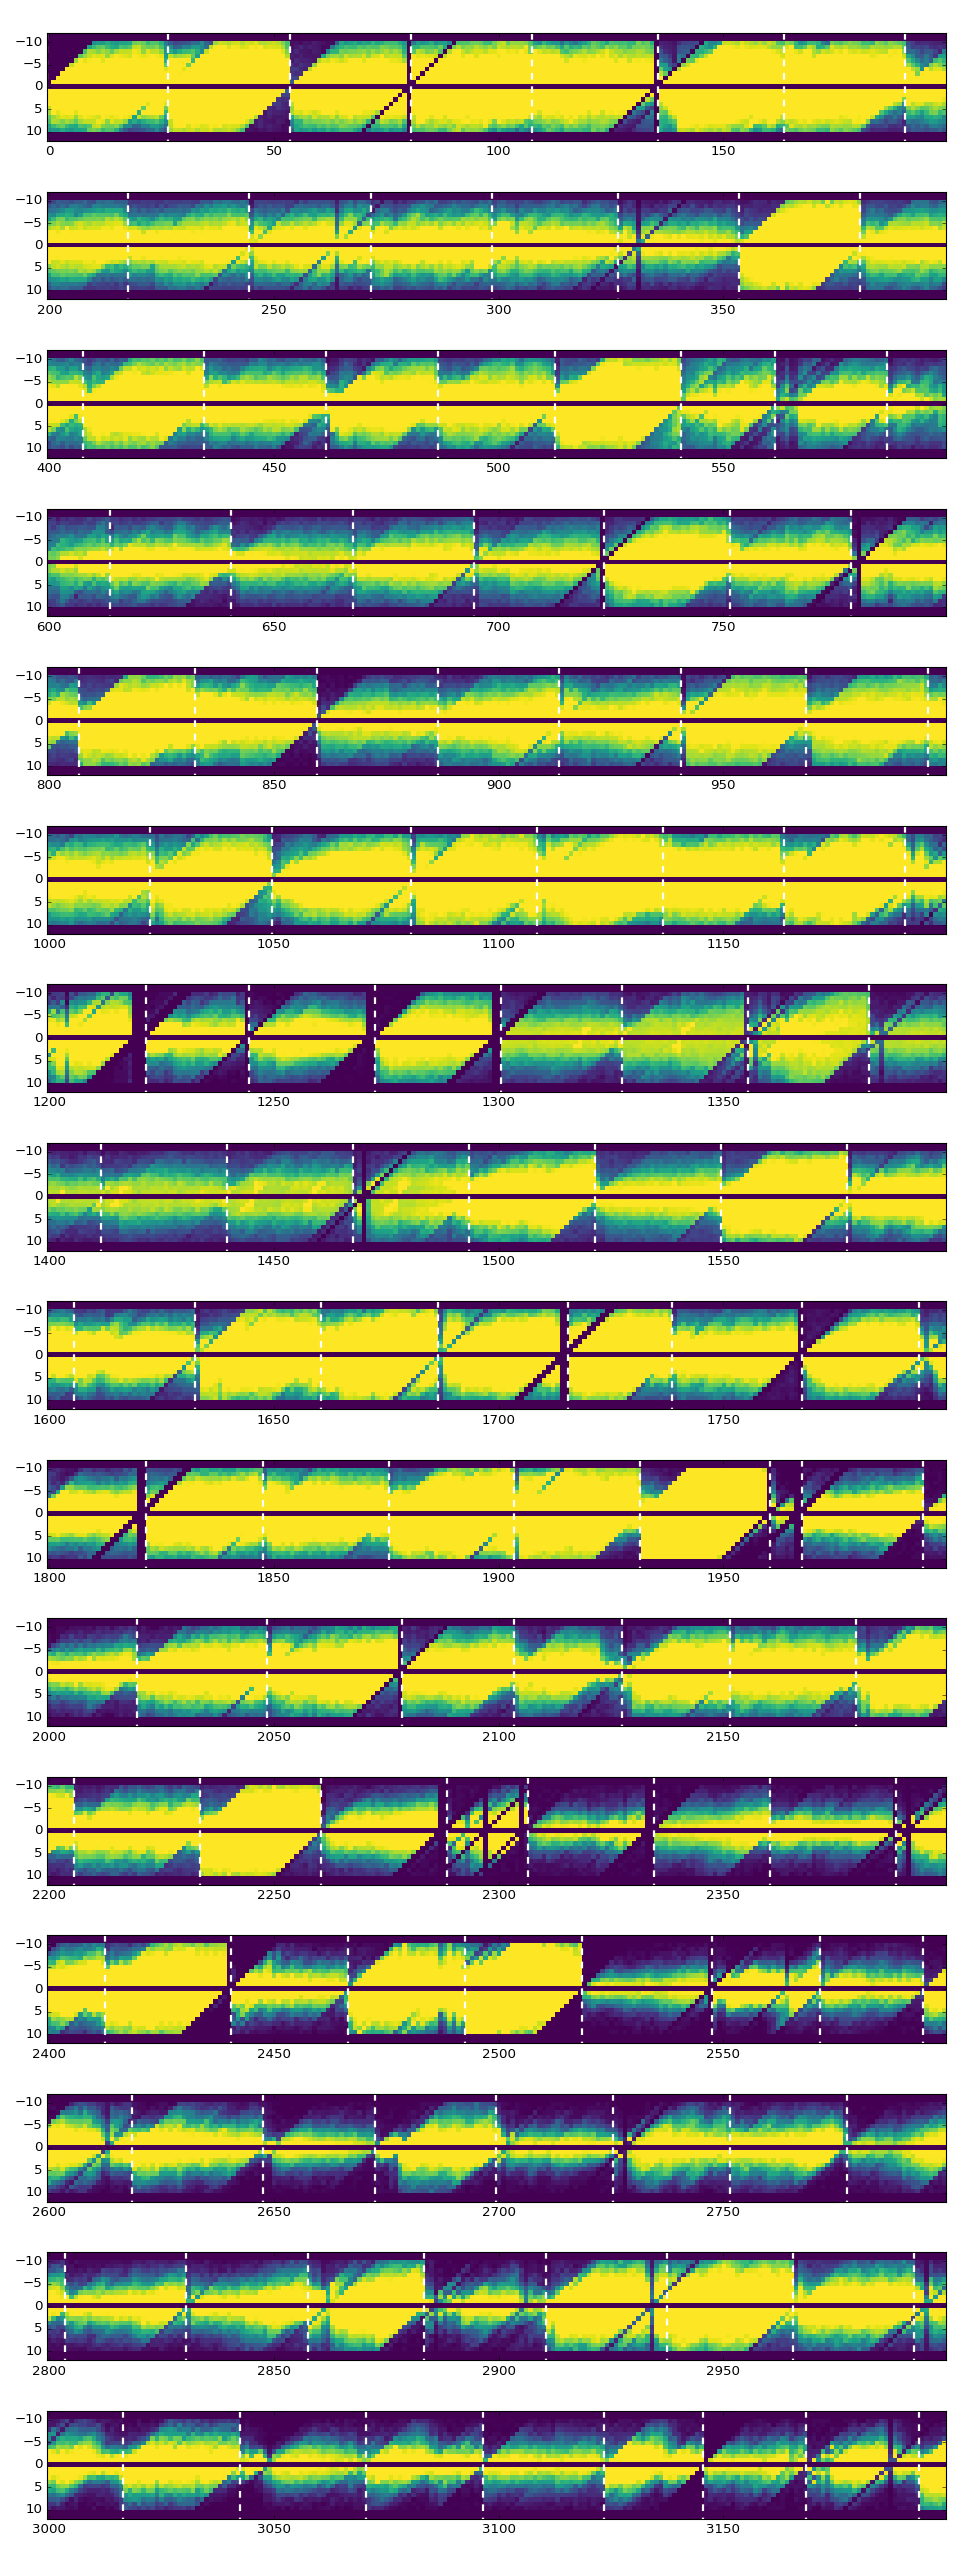

In [23]:
sections_per_row = 200
rows = int(np.ceil(maxz/sections_per_row))


f,ax = plt.subplots(rows,1,figsize=(12,2*rows))
first_section_indices=np.concatenate([np.array([0]),np.where(np.diff(groups%1000)<0)[0]+1])
first_sections=groups[first_section_indices]
first_section_zs = [zvalues[section] for section in first_sections]

for row in range(rows):
    startz = row*sections_per_row
    endz = row*sections_per_row + sections_per_row
    ax[row].imshow(match_matrix[startz:endz,:].T,interpolation='nearest',cmap=plt.cm.viridis,extent=(startz-.5,endz-.5,maxdz,-maxdz),vmin=0,vmax=200)
    ax[row].autoscale(tight=True)
    for z in first_section_zs:
        if (z>=startz)&(z<=endz):
            ax[row].plot([z-.5,z-.5],[-maxdz,maxdz],c='w',linewidth=2,linestyle='--')

# img=ax.imshow(match_matrix,interpolation='nearest',extent =(-maxdz,maxdz,maxz+.5,-.5))
# plt.xlabel('dz')
# plt.ylabel('z values')
# ax.set_title('matches')
# plt.colorbar(img)
plt.tight_layout()


# ax.set_yticks(np.arange(0,maxz,100))
#ax.autoscale(tight=True)

<IPython.core.display.Javascript object>


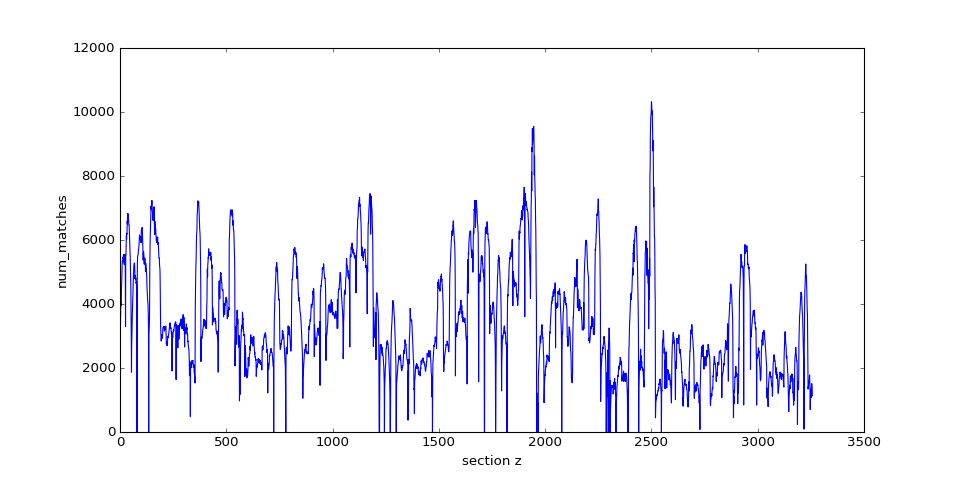

<IPython.core.display.Javascript object>


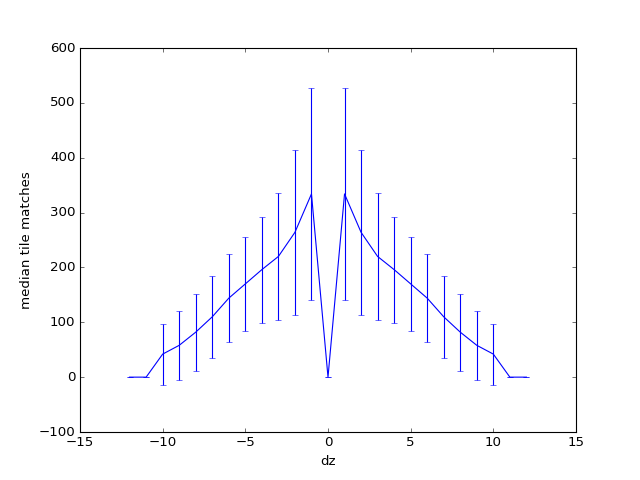

In [194]:
plt.figure(figsize=(12,6))
plt.plot(np.sum(match_matrix,axis=1))
plt.xlabel('section z')
plt.ylabel('num_matches')
plt.figure()
plt.errorbar(np.arange(-maxdz,maxdz+1).T,np.median(match_matrix,axis=0),np.std(match_matrix,axis=0))
plt.xlabel('dz')
plt.ylabel('median tile matches')

In [29]:
np.sum(np.sum(match_matrix,axis=1)==0)*1.0/match_matrix.shape[0]

0.011663597298956415

In [198]:
import networkx as nx
G=nx.Graph()


#subgroup =[group for i, group in enumerate(groups) if (zvalues[group]>1200) &  (zvalues[group]<1300)]
#subanswers =[answers[i] for i, group in enumerate(groups) if  (zvalues[group]>1200) &  (zvalues[group]<1300)]

G.add_nodes_from(groups)
for group in groups:
    G.node[group]['z']=zvalues[group]
    #    if zvalues[group]<100:
#        nx.set_node_attributes(G,'z',zvalues)

for answer,group in zip(answers,groups):
    for group2 in answer.keys():

        if G.has_edge(group,group2):
            w = G[group][group2]['weight']
            G[group][group2]['weight']=w+answer[group2]
        else:
            if group2=='z':
                print group,group2
            if group=='z':
                print group,group2
            G.add_edge(group,group2,weight=answer[group2])


In [199]:
subgraphs=nx.connected_components(G)
for sG in subgraphs:
    zs = np.array([G.node[node]['z'] for node in sG])
    print np.min(zs),'-',np.max(zs)

0 - 3145
3146 - 3257


In [186]:
sG

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 43013,
 45010,
 43014,
 41000,
 41001,
 41002,
 41003,
 41004,
 41005,
 41006,
 41007,
 41008,
 41009,
 41010,
 41011,
 41012,
 41013,
 41014,
 41015,
 41016,
 41017,
 41018,
 41019,
 41020,
 41021,
 41022,
 41023,
 41024,
 41025,
 41026,
 41027,
 43020,
 43021,
 43022,
 39000,
 39001,
 39002,
 39003,
 39004,
 39005,
 39006,
 39007,
 39008,
 39009,
 39010,
 39011,
 39012,
 39013,
 39014,
 39015,
 39016,
 39017,
 39018,
 39019,
 39020,
 39021,
 39022,
 39023,
 39024,
 39025,
 39026,
 39027,
 39028,
 39029,
 39030,
 45017,
 37000,
 37001,
 37002,
 37003,
 37004,
 37005,
 37006,
 37007,
 37008,
 37009,
 37010,
 37011,
 37012,
 37013,
 37014,
 37015,
 37016,
 37017,
 37018,
 37019,
 37020,
 37021,
 37022,
 37023,
 37024,
 37025,
 37026,
 35000,
 35001,
 35002,
 35003,
 35004,
 35005,
 35006,
 35007,
 35008,
 35009,
 35010,
 35011,
 35012,
 35013,
 35014,
 35015,
 35

In [200]:
import networkx as nx
G=nx.Graph()

subgroup =[group for i, group in enumerate(groups) if (zvalues[group]>3125) &  (zvalues[group]<3175)]
subanswers =[answers[i] for i, group in enumerate(groups) if  (zvalues[group]>3125) &  (zvalues[group]<3175)]

G.add_nodes_from(subgroup)
#for group in groups:
#    if zvalues[group]<100:
#        nx.set_node_attributes(G,'z',zvalues)

for answer,group in zip(subanswers,subgroup):
    for group2 in answer.keys():

        if G.has_edge(group,group2):
            w = G[group][group2]['weight']
            G[group][group2]['weight']=w+answer[group2]
        else:
            if group2=='z':
                print group,group2
            if group=='z':
                print group,group2
            G.add_edge(group,group2,weight=answer[group2])


In [201]:
def draw_network(G,pos,ax,sg=None):
    
    
    for n in G:
        c=Circle(pos[n],radius=.25,alpha=0.5)
        #ax.add_patch(c)
        p=ax.plot(pos[n][0],pos[n][1],'bo')
        G.node[n]['patch']=c
        x,y=pos[n]
        #print x,y
    seen={}
    #return
    for (u,v,d) in G.edges(data=True):
        x1,y1 = pos[u]
        x2,y2 = pos[v]
        n1=G.node[u]['patch']
        if v=='z':
            print u,v,d
        n2=G.node[v]['patch']
        dz=y2-y1
        rad = np.sqrt(dz)
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        color='k'
        
        cs = ConnectionStyle('Angle',angleA=45*(-1)**(dz%2), angleB=-45*(-1)**(dz%2), rad=10)
        
        linew = d['weight']*.1
        linew = min(linew,10)
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
#                            connectionstyle='arc3,rad=%s'%rad,
                            connectionstyle=cs,
                            mutation_scale=10.0,
                            lw=linew,
                            alpha=alpha,
                            color=color)
        seen[(u,v)]=rad
        ax.add_patch(e)
    return e

<IPython.core.display.Javascript object>


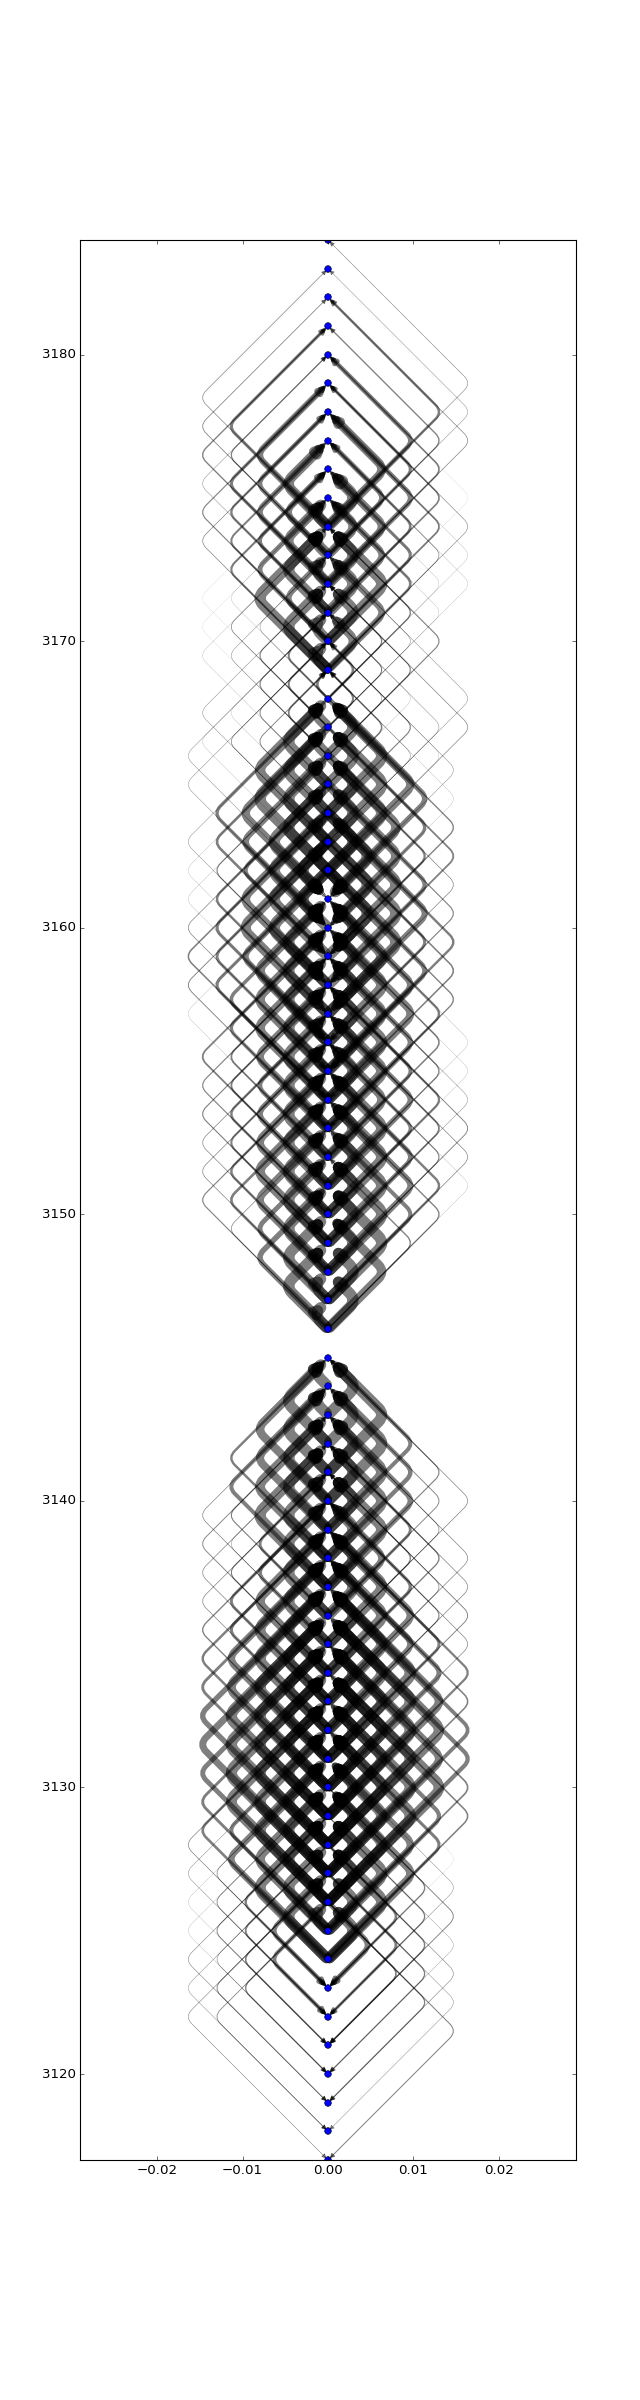

/pipeline/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt


In [202]:
pos={}
for node in G.nodes():
    pos[node]=(0,zvalues[node])
f,ax= plt.subplots(1,1,figsize=(8,30))
draw_network(G,pos,ax)
ax.autoscale(tight=True)
#ax.set_xlim([0,10])
#ax.set_ylim([-10,10])

In [74]:
pos

{0: (0, 0),
 1: (1, 0),
 2: (2, 0),
 3: (3, 0),
 4: (4, 0),
 5: (5, 0),
 6: (6, 0),
 7: (7, 0),
 8: (8, 0),
 9: (9, 0),
 10: (10, 0),
 11: (11, 0),
 12: (12, 0),
 13: (13, 0),
 14: (14, 0),
 15: (15, 0),
 16: (16, 0),
 17: (17, 0),
 18: (18, 0),
 19: (19, 0),
 20: (20, 0),
 21: (21, 0),
 22: (22, 0),
 23: (23, 0),
 24: (24, 0),
 25: (25, 0),
 26: (26, 0),
 1000: (27, 0),
 1001: (28, 0),
 1002: (29, 0),
 1003: (30, 0),
 1004: (31, 0),
 1005: (32, 0),
 1006: (33, 0),
 1007: (34, 0),
 1008: (35, 0),
 1009: (36, 0),
 1010: (37, 0),
 1011: (38, 0),
 1012: (39, 0),
 1013: (40, 0),
 1014: (41, 0),
 1015: (42, 0),
 1016: (43, 0),
 1017: (44, 0),
 1018: (45, 0),
 1019: (46, 0),
 1020: (47, 0),
 1021: (48, 0),
 1022: (49, 0),
 1023: (50, 0),
 1024: (51, 0),
 1025: (52, 0),
 1026: (53, 0),
 2000: (54, 0),
 2001: (55, 0),
 2002: (56, 0),
 2003: (57, 0),
 2004: (58, 0),
 2005: (59, 0),
 2006: (60, 0),
 2007: (61, 0),
 2008: (62, 0),
 2009: (63, 0),
 2010: (64, 0),
 2011: (65, 0),
 2012: (66, 0),
 2

In [58]:
for (u,v,d) in G.edges(data=True):
    if v=='z':
        print u,v,d
        break

0 z 0


In [ ]:
G[0]

In [9]:
#section_p= '0'
#section_q = '1'
#z_p=render.get_z_value_for_section(stack,section_p)
#z_q=render.get_z_value_for_section(stack,section_q)
z_p=0
z_q=1
section_p=[key for key in zvalues.keys() if zvalues[key]==z_p][0]
section_q=[key for key in zvalues.keys() if zvalues[key]==z_q][0]


bounds_p = render.get_bounds_from_z(stack,z_p)
bounds_q = render.get_bounds_from_z(stack,z_q)

scale=.1
lowmag_tile_p = render.get_png_tile(stack,z_p,bounds_p['minX'],bounds_p['minY'],bounds_p['maxX']-bounds_p['minX'],bounds_p['maxY']-bounds_p['minY'],scale=scale)
lowmag_tile_q = render.get_png_tile(stack,z_q,bounds_q['minX'],bounds_q['minY'],bounds_q['maxX']-bounds_q['minX'],bounds_q['maxY']-bounds_q['minY'],scale=scale)

In [10]:
allmatches = render.get_matches_from_group_to_group(matchcollection,section_p,section_q)
all_points_global_p = np.zeros((1,2))
all_points_global_q = np.zeros((1,2))
for matchobj in allmatches:
    points_local_p = np.array(matchobj['matches']['p'])
    points_local_q = np.array(matchobj['matches']['q'])
    #print matchobj,section_p,section_q
    
    t_p = render.local_to_world_coordinates_array(stack,points_local_p.T,matchobj['pId'],z_p)
    all_points_global_p=np.append(all_points_global_p,t_p,axis=0)
    t_q = render.local_to_world_coordinates_array(stack,points_local_q.T,matchobj['qId'],z_q)
    all_points_global_q=np.append(all_points_global_q,t_q,axis=0)

    #break
all_points_global_p = all_points_global_p[1:,:]
all_points_global_q = all_points_global_q[1:,:]


<IPython.core.display.Javascript object>


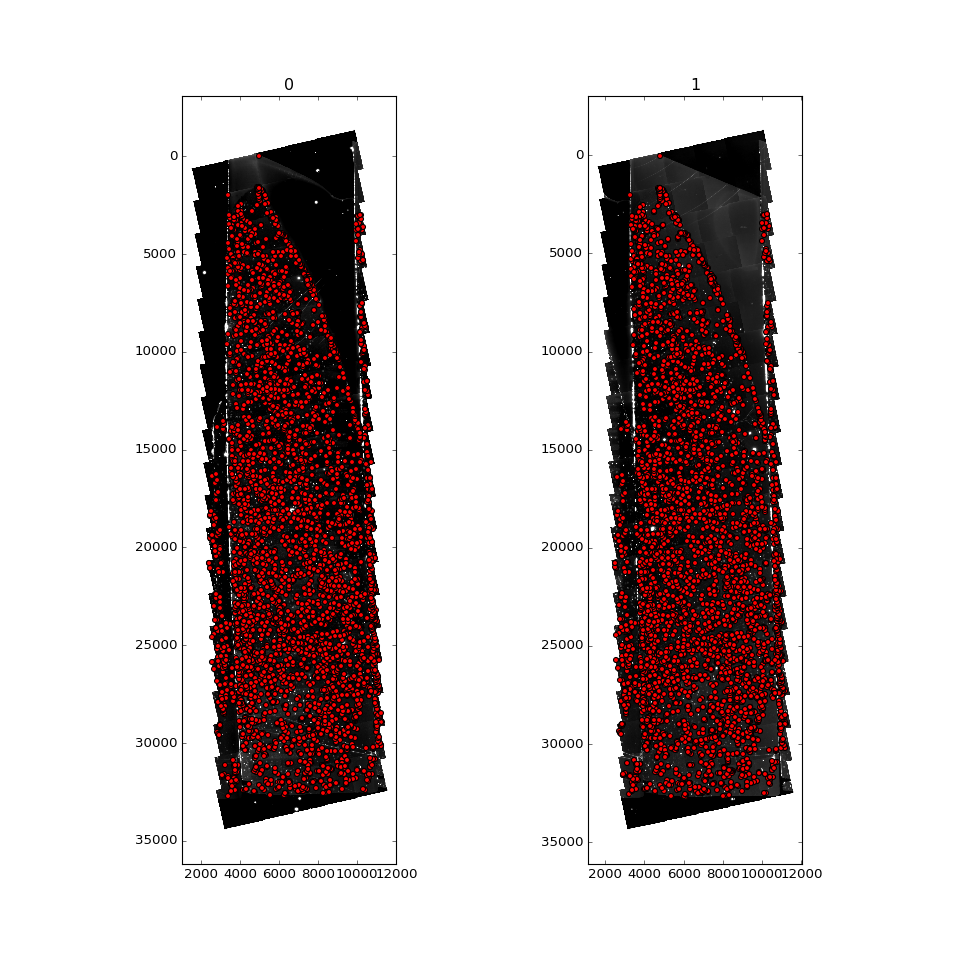

In [11]:
f,ax=plt.subplots(1,2,figsize=(12,12))
#imgjoin = np.concatenate([lowmag_tile_p,lowmag_tile_q],axis=1)
ax[0].imshow(lowmag_tile_p,extent=(bounds_p['minX'],bounds_p['maxX'],bounds_p['maxY'],bounds_p['minY']))
ax[1].imshow(lowmag_tile_q,extent=(bounds_q['minX'],bounds_q['maxX'],bounds_q['maxY'],bounds_q['minY']))
ax[0].scatter(all_points_global_p[:,0],all_points_global_p[:,1],c='r',zorder=8)
ax[1].scatter(all_points_global_q[:,0],all_points_global_q[:,1],c='r',zorder=8)
ax[0].autoscale(tight=True)
ax[1].autoscale(tight=True)
ax[0].set_title(z_p)
ax[1].set_title(z_q)
#transFigure = f.transFigure.inverted()
#coord1 = transFigure.transform(ax[0].transData.transform(all_points_global_p))
#coord2 = transFigure.transform(ax[1].transData.transform(all_points_global_q))
#coords=np.concatenate([coord1,coord2],axis=1)
#for coor in coords:
#    line = Line2D(coor[0:5:2]+.019,coor[1:5:2],
#                               transform=f.transFigure,zorder=9)
#    f.lines.append(line)



In [12]:
z_p=0
z_q=1
section_p=[key for key in zvalues.keys() if zvalues[key]==z_p][0]
section_q=[key for key in zvalues.keys() if zvalues[key]==z_q][0]
bounds_p = render.get_bounds_from_z(stack,z_p)
bounds_q = render.get_bounds_from_z(stack,z_q)

In [13]:
scale=.1
lowmag_tile_p = render.get_png_tile(stack,z_p,bounds_p['minX'],bounds_p['minY'],bounds_p['maxX']-bounds_p['minX'],bounds_p['maxY']-bounds_p['minY'],scale=scale)
lowmag_tile_q = render.get_png_tile(stack,z_q,bounds_p['minX'],bounds_p['minY'],bounds_p['maxX']-bounds_p['minX'],bounds_p['maxY']-bounds_p['minY'],scale=scale)
lowmag_rg = np.copy(lowmag_tile_p)
lowmag_rg[:,:,2]=lowmag_tile_q[:,:,1]
lowmag_rg[:,:,0]=0

In [14]:
allmatches = render.get_matches_from_group_to_group(matchcollection,section_p,section_q)
all_points_global_p = np.zeros((1,2))
all_points_global_q = np.zeros((1,2))
for matchobj in allmatches:
    points_local_p = np.array(matchobj['matches']['p'])
    points_local_q = np.array(matchobj['matches']['q'])
    #print matchobj,section_p,section_q
    
    t_p = render.local_to_world_coordinates_array(stack,points_local_p.T,matchobj['pId'],z_p)
    all_points_global_p=np.append(all_points_global_p,t_p,axis=0)
    t_q = render.local_to_world_coordinates_array(stack,points_local_q.T,matchobj['qId'],z_q)
    all_points_global_q=np.append(all_points_global_q,t_q,axis=0)

    #break
all_points_global_p = all_points_global_p[1:,:]
all_points_global_q = all_points_global_q[1:,:]


In [24]:
all_points=np.concatenate([all_points_global_p,all_points_global_q],axis=1)

In [16]:
all_points.shape

(6347, 4)

In [206]:
f,ax=plt.subplots(1,1,figsize=(7,20))
ax.imshow(lowmag_rg,extent=(bounds_p['minX'],bounds_p['maxX'],bounds_p['maxY'],bounds_p['minY']))
ax.plot(all_points[:,0:5:2].T,all_points[:,1:5:2].T,c='m')
ax.autoscale(tight=True)
plt.tight_layout()

<IPython.core.display.Javascript object>

NameError: name 'lowmag_rg' is not defined

<IPython.core.display.Javascript object>


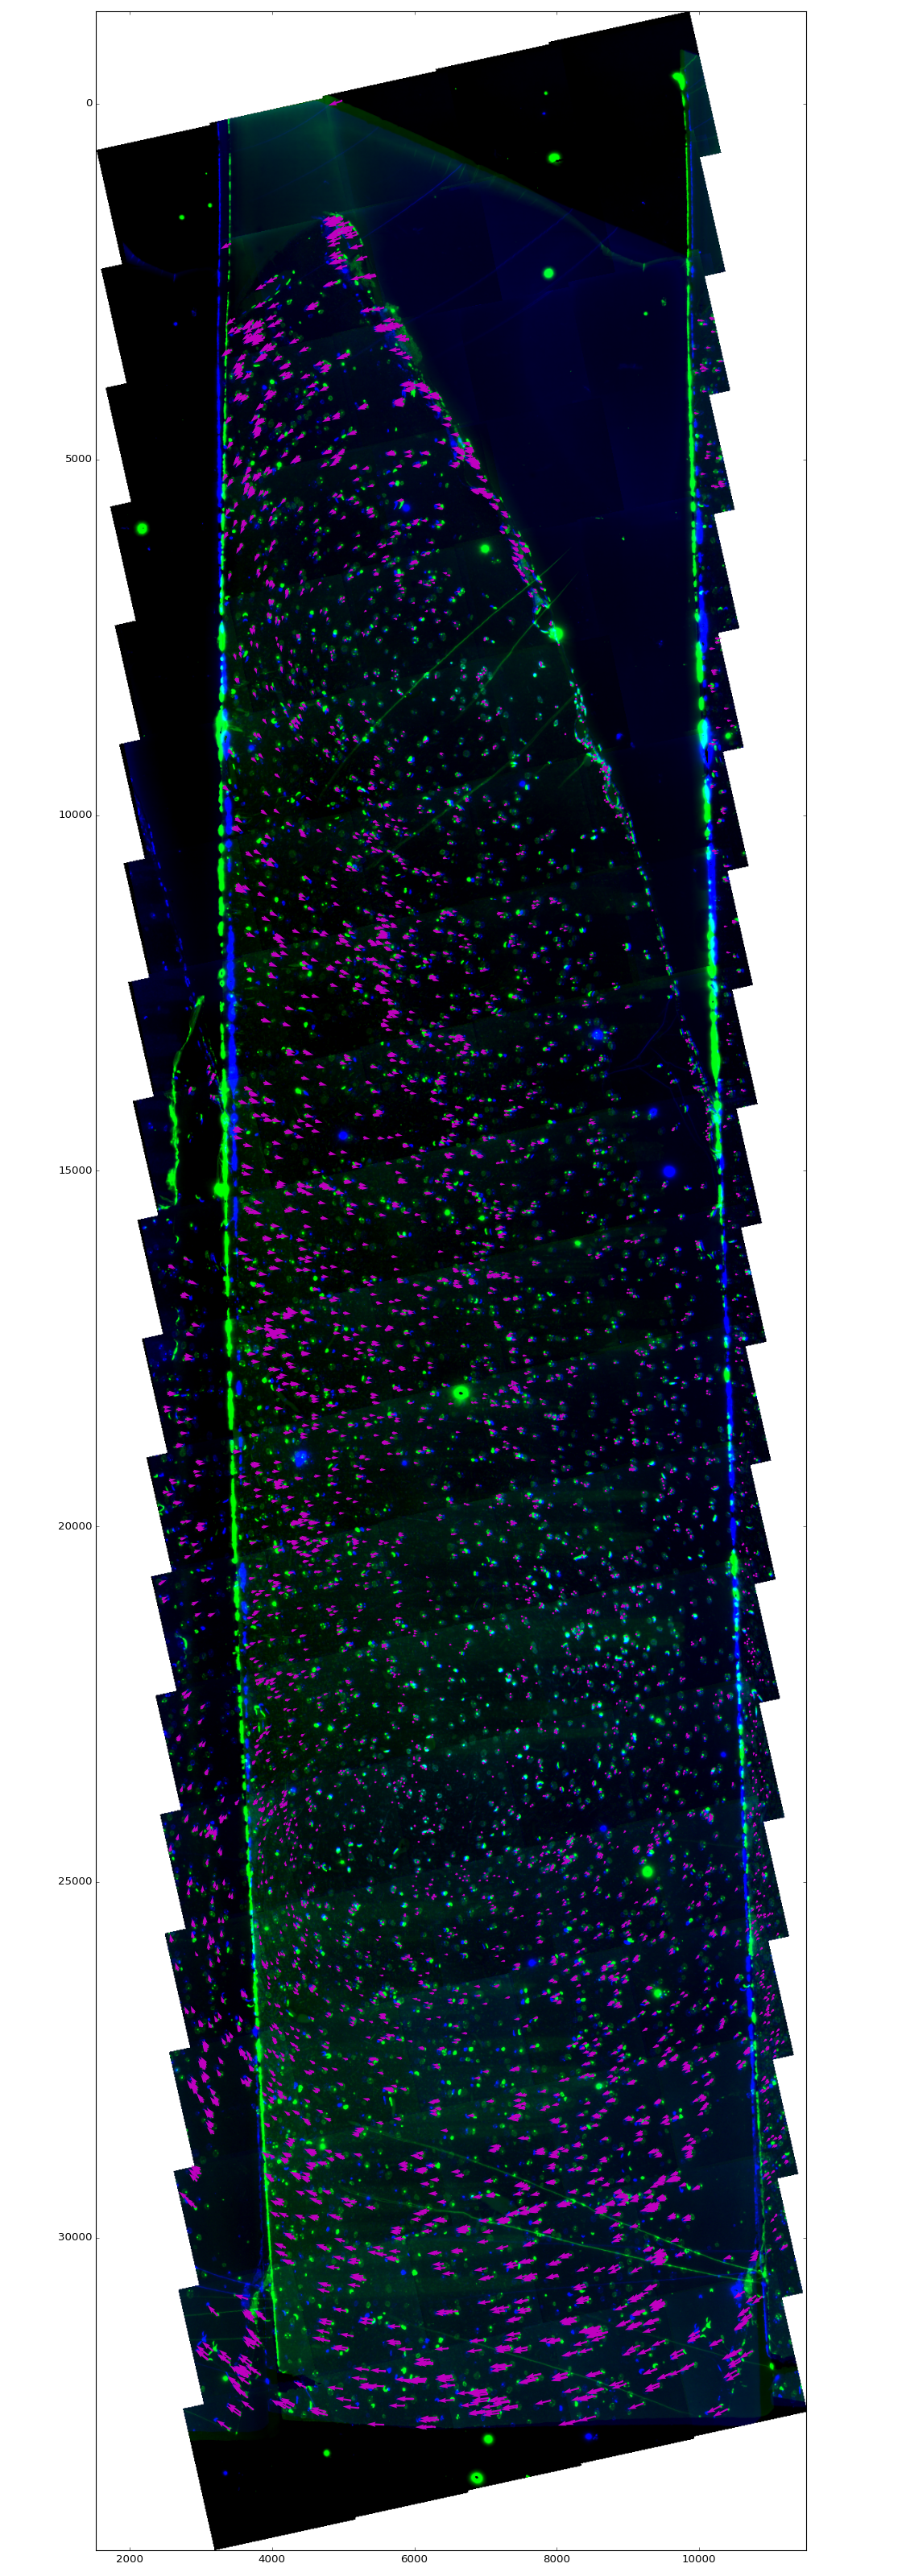

In [17]:
f,ax=plt.subplots(1,1,figsize=(14,40))
ax.imshow(lowmag_rg,extent=(bounds_p['minX'],bounds_p['maxX'],bounds_p['maxY'],bounds_p['minY']))
ax.scatter(all_points[:,0],all_points[:,1],c='m',marker='o',s=5,linewidth=0)
ax.quiver(all_points[:,0].T,all_points[:,1].T,
          all_points[:,2].T-all_points[:,0].T,
          all_points[:,3].T-all_points[:,1].T,
          color='m',
         angles='xy', scale_units='xy', scale=1)
ax.set_xlim((bounds_p['minX'],bounds_p['maxX']))
ax.set_ylim((bounds_p['maxY'],bounds_p['minY']))
#ax.autoscale(tight=True)
plt.tight_layout()

In [ ]:
f,ax=plt.subplots(1,1,figsize=(10,30))
ax.imshow(lowmag_rg,extent=(bounds_p['minX'],bounds_p['maxX'],bounds_p['maxY'],bounds_p['minY']))
ax.plot(all_points[:,0:5:2].T,all_points[:,1:5:2].T,c='m')
ax.autoscale(tight=True)
plt.tight_layout()

In [ ]:
print np.where(np.sum(match_matrix,axis=1)==0)
plt.figure()
plt.plot(np.sum(match_matrix,axis=1))

In [ ]:
plt.scatter?

In [ ]:
ax[0].scatter

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,12))

img=ax.imshow(match_matrix,interpolation='nearest')
plt.xlabel('section a')
plt.ylabel('section b')
ax.set_title('matches')
plt.colorbar(img)

In [ ]:
(z2-z1)

In [49]:
ts=render.get_tile_spec(stack,145000023044000)

In [50]:
ts.z

1242.0

In [18]:
all_points.shape

(6347, 4)

In [28]:
import json
jsonlist = []
for i in range(all_points.shape[0]):
    jsonlist.append([(all_points[i,0],all_points[i,1],z_p),(all_points[i,2],all_points[i,3],z_q)])



In [29]:
outfile = 'z0_z1_point_matches_global.json'
json.dump(jsonlist,open(outfile,'w'))